In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [4]:
def mirror_sequence(seq, window_size=33):
    """
    Mirror the sequence for padding positions on either left or right side
    window_size: total size of the window (should be odd number)
    """
    half_window = window_size // 2
    seq_list = list(seq)
    center = half_window  # K position
    
    # Check if padding is on the left side (N-terminus)
    if '-' in seq_list[:half_window]:
        left_valid = seq_list[:center]  # Get valid sequence up to K
        left_valid = [x for x in left_valid if x != '-']  # Remove padding
        needed_padding = half_window - len(left_valid)
        # Mirror from right side of K
        mirror_source = seq_list[center+1:center+1+needed_padding]
        mirror_source = mirror_source[::-1]  # Reverse the sequence
        seq_list[:needed_padding] = mirror_source
        
    # Check if padding is on the right side (C-terminus)
    elif '-' in seq_list[half_window+1:]:
        right_valid = seq_list[center+1:]  # Get valid sequence after K
        right_valid = [x for x in right_valid if x != '-']  # Remove padding
        needed_padding = half_window - len(right_valid)
        # Mirror from left side of K
        mirror_source = seq_list[center-needed_padding:center]
        mirror_source = mirror_source[::-1]  # Reverse the sequence
        seq_list[-needed_padding:] = mirror_source
    
    return ''.join(seq_list)

In [5]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding with mirroring"""
    # Updated alphabet without '-'
    alphabet = 'ARNDCQEGHILKMFPSTWYV'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            # Apply mirroring before encoding
            mirrored_seq = mirror_sequence(seq)
            integer_encoded = [char_to_int[char] for char in mirrored_seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {seq}")
            print(f"Error message: {e}")
            continue
    
    return np.array(encodings)

In [6]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        # Updated embedding dimension to 20 (for 20 amino acids)
        tf.keras.layers.Embedding(20, 20, input_length=33),
        tf.keras.layers.Reshape((33, 20, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [7]:
def train_and_evaluate():
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../new/processed_data_train.csv")
    test_df = pd.read_csv("../new/processed_data_test.csv")
    
    # Print class distribution
    print("Class Distribution:")
    print(train_df['label'].value_counts())
    
    # Print train and test set sizes
    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare sequence data
    print("Preparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    print(f"\nTraining data shape: {X_train_seq.shape}")
    print(f"Test data shape: {X_test_seq.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print("\nClass weights:", class_weights)
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    metrics = {'acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("Training model...")
        history = model.fit(
            X_train_seq[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train_seq[val_idx], y_train[val_idx]),
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        # plt.savefig(f'accuracy_fold_{fold}.png')
        # plt.close()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_seq[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test_seq)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Class Distribution:
label
1    4591
0    4259
Name: count, dtype: int64
Train set size: 8850
Test set size: 2737
Preparing sequence data...

Training data shape: (8850, 33)
Test data shape: (2737, 33)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-27 13:15:59.680945: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-27 13:15:59.680971: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-27 13:15:59.680979: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-27 13:15:59.681179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-27 13:15:59.681192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...
Epoch 1/50


2024-11-27 13:16:00.335261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5273 - loss: 0.6906 - val_accuracy: 0.6435 - val_loss: 0.6481
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6569 - loss: 0.6205 - val_accuracy: 0.6966 - val_loss: 0.5781
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7265 - loss: 0.5496 - val_accuracy: 0.7260 - val_loss: 0.5541
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7510 - loss: 0.5262 - val_accuracy: 0.7260 - val_loss: 0.5458
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7608 - loss: 0.5102 - val_accuracy: 0.7311 - val_loss: 0.5439
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7703 - loss: 0.4966 - val_accuracy: 0.7373 - val_loss: 0.5412
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7729 - loss: 0.4838 - val_accuracy: 0.7277 - val_loss: 0.5429
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7791 - loss: 0.4707 - val_accuracy: 0.726

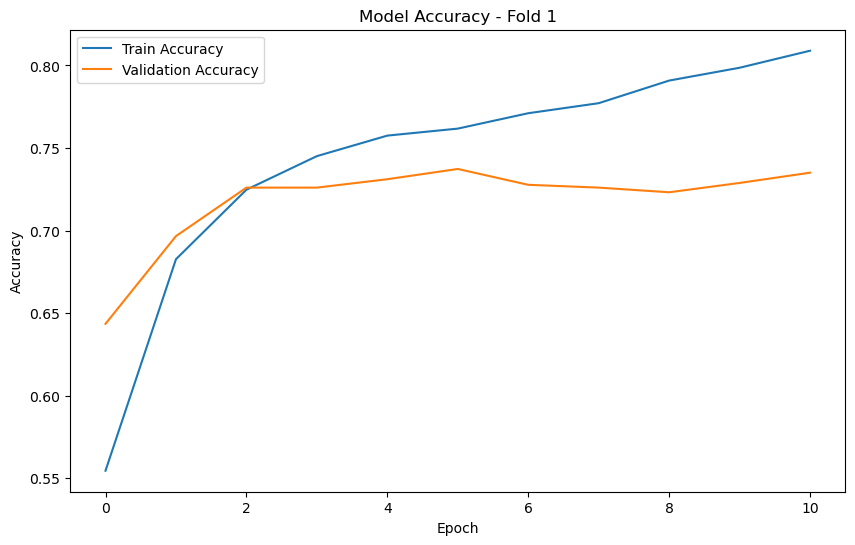

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 1 Results:
Accuracy: 0.7373
MCC: 0.4711
Sensitivity: 0.7521
Specificity: 0.7196

Fold 2/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5169 - loss: 0.6888 - val_accuracy: 0.6452 - val_loss: 0.6382
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6676 - loss: 0.6164 - val_accuracy: 0.6910 - val_loss: 0.5834
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7231 - loss: 0.5554 - val_accuracy: 0.7232 - val_loss: 0.5498
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7526 - loss: 0.5218 - val_accuracy: 0.7271 - val_loss: 0.5439
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7629 - loss: 0.5028 - val_accuracy: 0.7311 - val_loss: 0.5403
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7657 - loss: 0.4928 - val_accuracy: 0.7362 - val_loss: 0.5321
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7810 - loss: 0.4780 - val_accuracy: 0.7367 - val_loss: 0.5319
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7850 - loss: 0.4660 - val_accuracy: 0.73

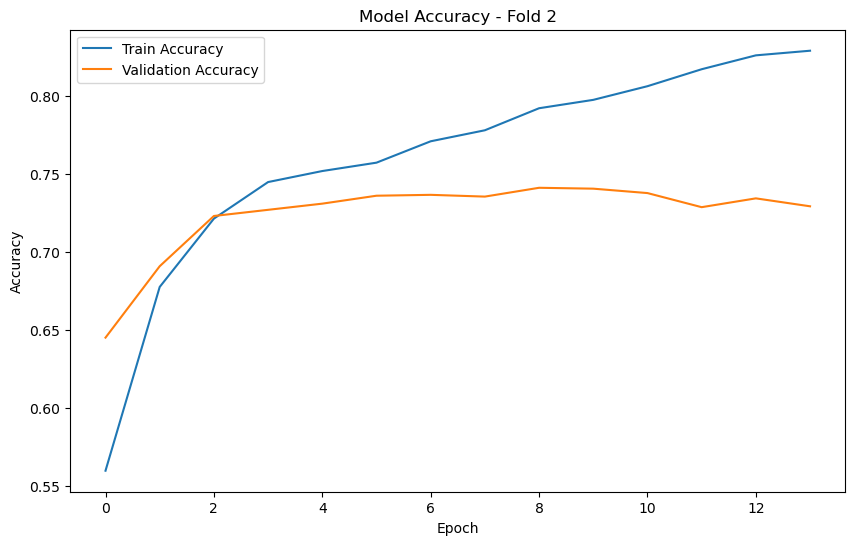

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7412
MCC: 0.4876
Sensitivity: 0.8702
Specificity: 0.5952

Fold 3/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5138 - loss: 0.6913 - val_accuracy: 0.6147 - val_loss: 0.6547
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6474 - loss: 0.6383 - val_accuracy: 0.6644 - val_loss: 0.6096
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7014 - loss: 0.5813 - val_accuracy: 0.7124 - val_loss: 0.5683
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7357 - loss: 0.5456 - val_accuracy: 0.7175 - val_loss: 0.5645
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7472 - loss: 0.5239 - val_accuracy: 0.7249 - val_loss: 0.5572
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7566 - loss: 0.5113 - val_accuracy: 0.7181 - val_loss: 0.5625
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7655 - loss: 0.5017 - val_accuracy: 0.7226 - val_loss: 0.5601
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7779 - loss: 0.4812 - val_accuracy: 0.727

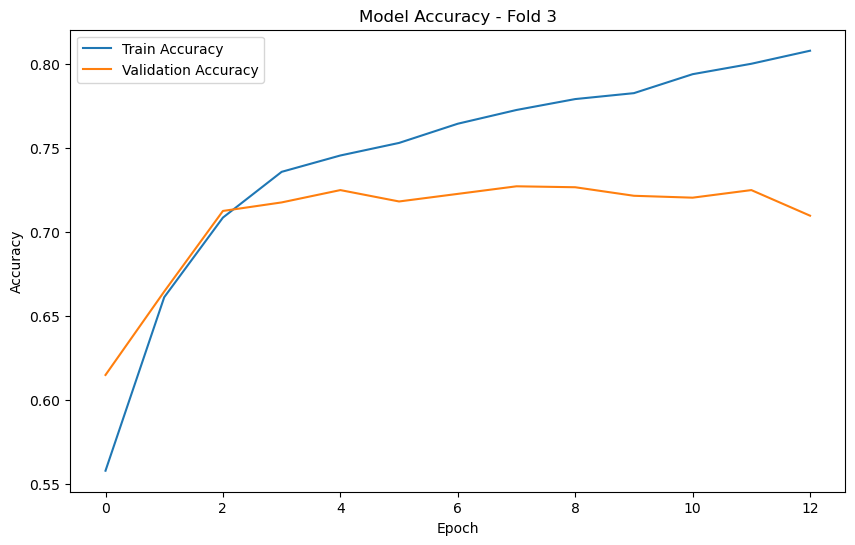

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.7271
MCC: 0.4729
Sensitivity: 0.8723
Specificity: 0.5792

Fold 4/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5207 - loss: 0.6887 - val_accuracy: 0.6475 - val_loss: 0.6335
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6575 - loss: 0.6235 - val_accuracy: 0.7153 - val_loss: 0.5770
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7012 - loss: 0.5768 - val_accuracy: 0.7350 - val_loss: 0.5457
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7273 - loss: 0.5372 - val_accuracy: 0.7424 - val_loss: 0.5324
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7472 - loss: 0.5301 - val_accuracy: 0.7463 - val_loss: 0.5276
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7421 - loss: 0.5157 - val_accuracy: 0.7418 - val_loss: 0.5249
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7538 - loss: 0.4972 - val_accuracy: 0.7475 - val_loss: 0.5238
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7699 - loss: 0.4899 - val_accuracy: 0.739

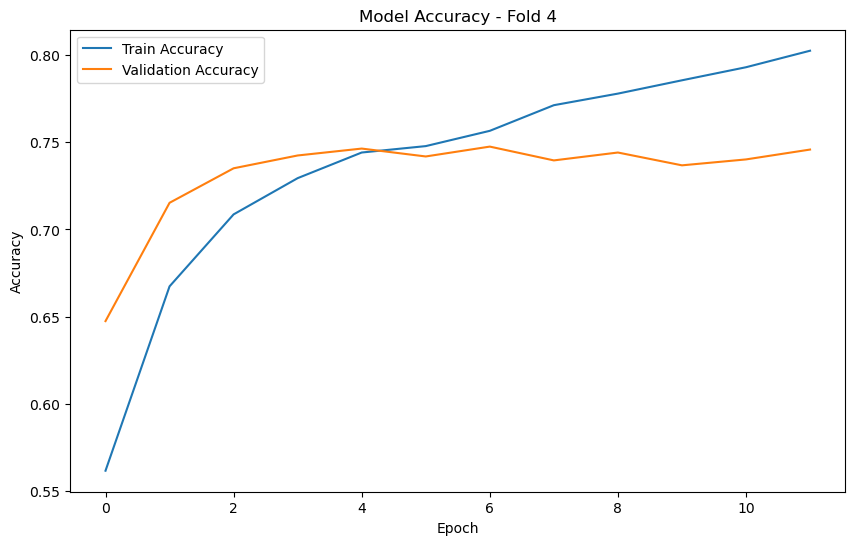

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4 Results:
Accuracy: 0.7475
MCC: 0.5004
Sensitivity: 0.8168
Specificity: 0.6790

Fold 5/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5200 - loss: 0.6906 - val_accuracy: 0.6514 - val_loss: 0.6367
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6525 - loss: 0.6259 - val_accuracy: 0.7017 - val_loss: 0.5773
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7167 - loss: 0.5599 - val_accuracy: 0.7299 - val_loss: 0.5505
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7302 - loss: 0.5360 - val_accuracy: 0.7299 - val_loss: 0.5408
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7503 - loss: 0.5151 - val_accuracy: 0.7311 - val_loss: 0.5340
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7587 - loss: 0.5002 - val_accuracy: 0.7288 - val_loss: 0.5344
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7728 - loss: 0.4842 - val_accuracy: 0.7288 - val_loss: 0.5306
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7797 - loss: 0.4718 - val_accuracy: 0.733

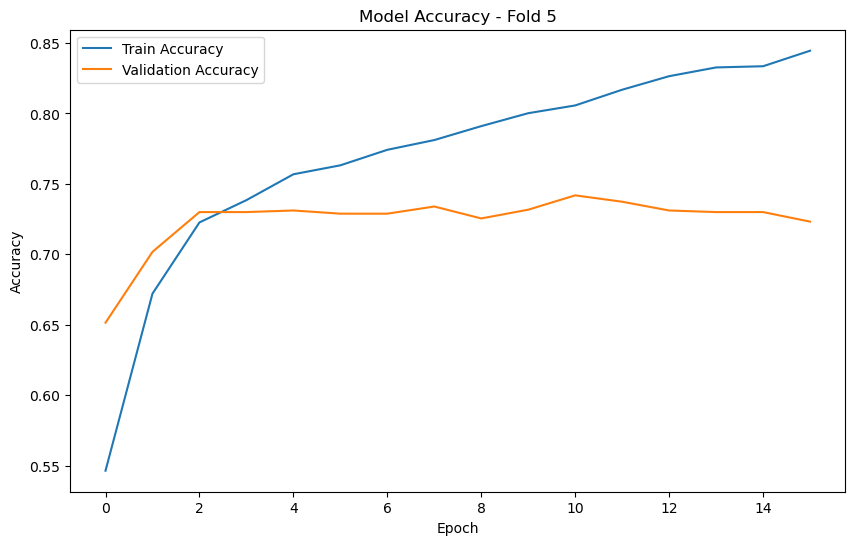

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7418
MCC: 0.4828
Sensitivity: 0.7607
Specificity: 0.7216

Average Cross-validation Results:
ACC: 0.7390 ± 0.0068
MCC: 0.4829 ± 0.0106
SN: 0.8144 ± 0.0515
SP: 0.6589 ± 0.0607

Final Test Set Results:
Accuracy: 0.6628
MCC: 0.2837
Sensitivity: 0.8458
Specificity: 0.6452
Confusion Matrix:
[[1611  886]
 [  37  203]]


In [8]:
if __name__ == "__main__":
    model = train_and_evaluate()

In [9]:
print("Loading data...")
train_df = pd.read_csv("../new/processed_data_train.csv")
test_df = pd.read_csv("../new/processed_data_test.csv")

# Print class distribution
print("Class Distribution:")
print(train_df['label'].value_counts())

# Print train and test set sizes
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Shuffle the training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare sequence data
print("Preparing sequence data...")
X_train_seq = prepare_sequence_data(train_df)
X_test_seq = prepare_sequence_data(test_df)

Loading data...
Class Distribution:
label
1    4591
0    4259
Name: count, dtype: int64
Train set size: 8850
Test set size: 2737
Preparing sequence data...


In [10]:
X_train_seq

array([[ 0,  2,  5, ...,  1,  6,  9],
       [15, 19,  0, ...,  4,  9,  7],
       [15, 13,  7, ...,  7, 10,  5],
       ...,
       [ 5,  9, 12, ..., 14, 11,  1],
       [ 9,  8, 11, ..., 14, 18,  7],
       [ 3,  0,  3, ...,  2, 19,  0]])